<a href="https://colab.research.google.com/github/nadaz10/NER-using-NN-and-LSTM/blob/main/A3P2_Named_Entity_Recognition_LSTMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook for Programming in Problem 2


## Learning Objectives
In this problem, we will use [PyTorch](https://pytorch.org/) to implement long short-term memory (LSTM) for named entity recognition (NER). We will use the same dataset and boilerplate code as in Programming Problem 1 of Assignment #3.

## Writing Code
Look for the keyword "TODO" and fill in your code in the empty space.
Feel free to change function signatures, but be careful that you might need to also change how they are called in other parts of the notebook.

In [1]:
!nvidia-smi # you may need to try reconnecting to get a T4 gpu

Sat Apr 27 14:52:19 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Installing PyTorch and Other Packages

Install PyTorch using pip. See [https://pytorch.org/](https://pytorch.org/) if you want to install it on your computer.

In [2]:
!pip install torch torchtext -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64

Test if our installation works:

In [3]:
import torch

# Multiply two matrices on GPU
a = torch.rand(100, 200).cuda()
b = torch.rand(200, 100).cuda()
c = torch.matmul(a, b)

print("PyTorch successfully installed!")
print("Version:", torch.__version__)

PyTorch successfully installed!
Version: 2.2.1+cu121


Also install [scikit-learn](https://scikit-learn.org/stable/). We will use it for calculating evaluation metrics such as accuracy and F1 score.

In [4]:
!pip install -U scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 32.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


Let's import all the packages at once:

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchtext.vocab import Vocab, vocab
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import re
from collections import Counter
from typing import List, Tuple, Dict, Optional, Any

## Long Short Term Memory (LSTM)

### Data Loading

We will use the same dataset for named entity recognition in Assignment #2. First download the data and take a look at the first 50 lines:

In [7]:
!wget --quiet https://princeton-nlp.github.io/cos484/assignments/a2/eng.train
!wget --quiet https://princeton-nlp.github.io/cos484/assignments/a2/eng.val
!cat eng.train | head -n 50
#The --quiet is used to suppress output message

EU NNP I-NP ORG
rejects VBZ I-VP O
German JJ I-NP MISC
call NN I-NP O
to TO I-VP O
boycott VB I-VP O
British JJ I-NP MISC
lamb NN I-NP O
. . O O

Peter NNP I-NP PER
Blackburn NNP I-NP PER

BRUSSELS NNP I-NP LOC
1996-08-22 CD I-NP O

The DT I-NP O
European NNP I-NP ORG
Commission NNP I-NP ORG
said VBD I-VP O
on IN I-PP O
Thursday NNP I-NP O
it PRP B-NP O
disagreed VBD I-VP O
with IN I-PP O
German JJ I-NP MISC
advice NN I-NP O
to TO I-PP O
consumers NNS I-NP O
to TO I-VP O
shun VB I-VP O
British JJ I-NP MISC
lamb NN I-NP O
until IN I-SBAR O
scientists NNS I-NP O
determine VBP I-VP O
whether IN I-SBAR O
mad JJ I-NP O
cow NN I-NP O
disease NN I-NP O
can MD I-VP O
be VB I-VP O
transmitted VBN I-VP O
to TO I-PP O
sheep NN I-NP O
. . O O

Germany NNP I-NP LOC
's POS B-NP O
representative NN I-NP O


Each line corresponds to a word. Different sentences are separated by an additional line break. Take "EU NNP I-NP ORG" as an example. "EU" is a word. "NNP" and "I-NP" are tags for POS tagging and chunking, which we will ignore. "ORG" is the tag for NER, which is our prediction target. There are 5 possible values for the NER tag: ORG, PER, LOC, MISC, and O.



In [8]:
# A sentence is a list of (word, tag) tuples.
# For example, [("hello", "O"), ("world", "O"), ("!", "O")]
Sentence = List[Tuple[str, str]]


def read_data_file(
    datapath: str,
) -> Tuple[List[Sentence], Dict[str, int], Dict[str, int]]:
    """
    Read and preprocess input data from the file `datapath`.
    Example:
    ```
        sentences, word_cnt, tag_cnt = read_data_file("eng.train")
    ```
    Return values:
        `sentences`: a list of sentences, including words and NER tags
        `word_cnt`: a Counter object, the number of occurrences of each word
        `tag_cnt`: a Counter object, the number of occurences of each NER tag
    """
    sentences: List[Sentence] = []
    word_cnt: Dict[str, int] = Counter()
    tag_cnt: Dict[str, int] = Counter()

    for sentence_txt in open(datapath).read().split("\n\n"):
        if "DOCSTART" in sentence_txt:
            # Ignore dummy sentences at the begining of each document.
            continue
        # Read a new sentence
        sentences.append([])
        for token in sentence_txt.split("\n"):
            w, _, _, t = token.split()
            # Replace all digits with "0" to reduce out-of-vocabulary words
            w = re.sub("\d", "0", w)
            word_cnt[w] += 1
            tag_cnt[t] += 1
            sentences[-1].append((w, t))

    return sentences, word_cnt, tag_cnt



In [9]:
# Some helper code
def get_device() -> torch.device:
    """
    Use GPU when it is available; use CPU otherwise.
    See https://pytorch.org/docs/stable/notes/cuda.html#device-agnostic-code
    """
    return torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


In [10]:
def eval_metrics(ground_truth: List[int], predictions: List[int]) -> Dict[str, Any]:
    """
    Calculate various evaluation metrics such as accuracy and F1 score
    Parameters:
        `ground_truth`: the list of ground truth NER tags
        `predictions`: the list of predicted NER tags
    """
    f1_scores = f1_score(ground_truth, predictions, average=None)
    return {
        "accuracy": accuracy_score(ground_truth, predictions),
        "f1": f1_scores,
        "average f1": np.mean(f1_scores),
        "confusion matrix": confusion_matrix(ground_truth, predictions),
    }

## Long Short-term Memory (LSTM)

Now we implement an one-layer LSTM for the same task and compare it to FFNNs.

LSTM Cell
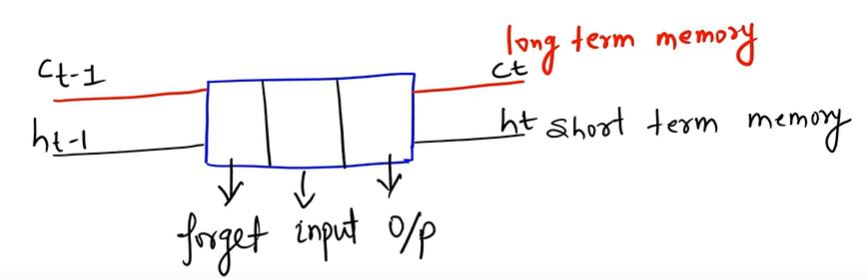

### Data Loading **(4 points)**

Like before, we first implement the data loader. But unlike before, each data example is now a variable-length sentence. How can we pack multiple sentences with different lengths into the same batch? One possible solution is to pad them to the same length using a special token. The code below illustrates the idea:

In [11]:
# 3 sentences with different lengths
sentence_1 = torch.tensor([6, 1, 2])
sentence_2 = torch.tensor([4, 2, 7, 7, 9])
sentence_3 = torch.tensor([3, 4])
# Form a batch by padding 0
sentence_batch = torch.tensor([
    [6, 1, 2, 0, 0],
    [4, 2, 7, 7, 9],
    [3, 4, 0, 0, 0],
])

We implement the above idea in a customized batching function `form_batch`. Optionally, see [here](https://pytorch.org/docs/stable/data.html#loading-batched-and-non-batched-data) for how batching works in PyTorch.

In [20]:
class SequenceDataset(Dataset):
    """
    Each data example is a sentence, including its words and NER tags.
    """

    def __init__(
        self, datapath: str, words_vocab: Optional[Vocab] = None, tags_vocab: Optional[Vocab] = None
    ) -> None:
        """
        Initialize the dataset by reading from datapath.
        """
        super().__init__()
        self.sentences: List[Sentence] = []
        UNKNOWN = "<UNKNOWN>"
        PAD = "<PAD>"  # Special token used for padding

        print("Loading data from %s" % datapath)
        self.sentences, word_cnt, tag_cnt = read_data_file(datapath)
        print("%d sentences loaded." % len(self.sentences))

        if words_vocab is None:
            words_vocab = vocab(word_cnt, specials=[PAD, UNKNOWN])
            words_vocab.set_default_index(words_vocab[UNKNOWN])

        self.words_vocab = words_vocab

        self.unknown_idx = self.words_vocab[UNKNOWN]
        self.pad_idx = self.words_vocab[PAD]

        if tags_vocab is None:
            tags_vocab = vocab(tag_cnt, specials=[])
        self.tags_vocab = tags_vocab

    def __getitem__(self, idx: int) -> Sentence:
        """
        Get the idx'th sentence in the dataset.
        """
        return self.sentences[idx]

    def __len__(self) -> int:
        """
        Return the number of sentences in the dataset.
        """
        # TODO: Implement this method          ########## DONE
        # START HERE
        #raise NotImplementedError
        return len(self.sentences)
        # END

    def form_batch(self, sentences: List[Sentence]) -> Dict[str, Any]:
        """
        A customized function for batching a number of sentences together.
        Different sentences have different lengths. Let max_len be the longest length.
        When packing them into one tensor, we need to pad all sentences to max_len.
        Return values:
            `words`: a list in which each element itself is a list of words in a sentence
            `word_idxs`: a batch_size x max_len tensor.
                       word_idxs[i][j] is the index of the j'th word in the i'th sentence .
            `tags`: a list in which each element itself is a list of tags in a sentence
            `tag_idxs`: a batch_size x max_len tensor
                      tag_idxs[i][j] is the index of the j'th tag in the i'th sentence.
            `valid_mask`: a batch_size x max_len tensor
                        valid_mask[i][j] is True if the i'th sentence has the j'th word.
                        Otherwise, valid[i][j] is False.
        """
        words: List[List[str]] = []
        tags: List[List[str]] = []
        max_len = -1  # length of the longest sentence
        for sent in sentences: #For each sentence,append an empty list to words and tags, creating placeholders to store the words and tags of the sentence.
            words.append([])
            tags.append([])
            for w, t in sent:
                words[-1].append(w)
                tags[-1].append(t)
            max_len = max(max_len, len(words[-1]))

        batch_size = len(sentences)  #calculate total number of sentences in the current batch.
        word_idxs = torch.full(
            (batch_size, max_len), fill_value=self.pad_idx, dtype=torch.int64
        ) #initialize a tensor word_idxs with dimensions (batch_size, max_len) filled with the padding index self.pad_idx.
        tag_idxs = torch.full_like(word_idxs, fill_value=self.tags_vocab["O"]) #tensor filled with the index of the "O" tag in the tag vocabulary.
        valid_mask = torch.zeros_like(word_idxs, dtype=torch.bool) #will indicate whether a word is valid (True) or padded (False) in each sentence.

        ## TODO: Fill in the values in word_idxs, tag_idxs, and valid_mask                      ##################### DONE
        ## Caveat: There may be out-of-vocabulary words in validation data
        ## See torchtext.vocab.Vocab: https://pytorch.org/text/stable/vocab.html#torchtext.vocab.Vocab

        ## START HERE
        for i, sent in enumerate(sentences):
            for j, (w, t) in enumerate(sent):
                word_idxs[i][j] = self.words_vocab[w]  # Assign index of word in vocabulary
                tag_idxs[i][j] = self.tags_vocab[t]    # Assign index of tag in vocabulary
                valid_mask[i][j] = True                # Mark as valid word
        # END

        return {
            "words": words,
            "word_idxs": word_idxs,
            "tags": tags,
            "tag_idxs": tag_idxs,
            "valid_mask": valid_mask,
        }


def create_sequence_dataloaders(
    batch_size: int, shuffle: bool = True
) -> Tuple[DataLoader, DataLoader, Vocab]:
    """
    Create the dataloaders for training and validaiton.
    """
    ds_train = SequenceDataset("eng.train")
    ds_val = SequenceDataset("eng.val", words_vocab=ds_train.words_vocab, tags_vocab=ds_train.tags_vocab)
    loader_train = DataLoader(
        ds_train,
        batch_size,
        shuffle,
        collate_fn=ds_train.form_batch,  # customized function for batching
        drop_last=True,
        pin_memory=True,
    )
    loader_val = DataLoader(
        ds_val, batch_size, collate_fn=ds_val.form_batch, pin_memory=True
    )
    return loader_train, loader_val, ds_train #a tuple containing two DataLoader objects for training and validation datasets,and vocabulary object used for the training dataset.
#shuffle (whether to shuffle the data during batching)
#This creates a PyTorch DataLoader object loader_train for the training dataset.
#It takes the training dataset ds_train, batch size batch_size, shuffle flag shuffle, and specifies a custom batching function ds_train.form_batch.
#The collate_fn argument specifies how to batch individual data samples together, using the form_batch method of the ds_train object.
#drop_last=True ensures that the last incomplete batch is dropped if its size is less than the specified batch size.
#pin_memory=True is used to enable faster data transfer to GPU memory if available.
#pin_memory=True is used to enable faster data transfer to GPU memory if available.


Here is a simple sanity-check. Try to understand its output.

In [18]:
def check_sequence_dataloader() -> None:
    loader_train, _, _ = create_sequence_dataloaders(batch_size=3, shuffle=False)
    print("Iterating on the training data..")
    for i, data_batch in enumerate(loader_train):
        if i == 0:
            print(data_batch)
    print("Done!")


check_sequence_dataloader()

Loading data from eng.train
14041 sentences loaded.
Loading data from eng.val
3490 sentences loaded.
Iterating on the training data..
{'words': [['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'], ['Peter', 'Blackburn'], ['BRUSSELS', '0000-00-00']], 'word_idxs': tensor([[ 2,  3,  4,  5,  6,  7,  8,  9, 10],
        [11, 12,  0,  0,  0,  0,  0,  0,  0],
        [13, 14,  0,  0,  0,  0,  0,  0,  0]]), 'tags': [['ORG', 'O', 'MISC', 'O', 'O', 'O', 'MISC', 'O', 'O'], ['PER', 'PER'], ['LOC', 'O']], 'tag_idxs': tensor([[0, 1, 2, 1, 1, 1, 2, 1, 1],
        [3, 3, 1, 1, 1, 1, 1, 1, 1],
        [4, 1, 1, 1, 1, 1, 1, 1, 1]]), 'valid_mask': tensor([[ True,  True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True, False, False, False, False, False, False, False],
        [ True,  True, False, False, False, False, False, False, False]])}
Done!


### Better Visualization for previous output

In [21]:
pip install tabulate


In [25]:
from tabulate import tabulate

def visualize_batch(batch_data: Dict[str, Any]) -> None:
    """
    Visualizes the batch data in a table format.
    """
    words = batch_data["words"]
    tags = batch_data["tags"]
    word_idxs = batch_data["word_idxs"]
    tag_idxs = batch_data["tag_idxs"]
    valid_mask = batch_data["valid_mask"]

    table_data = []
    for i in range(len(words)):
        table_data.append(["Sentence " + str(i + 1), "", "", "", ""])
        table_data.extend(zip(words[i], tags[i], word_idxs[i], tag_idxs[i], valid_mask[i]))

    headers = ["Word", "Tag", "Word Index", "Tag Index", "Valid"]
    print(tabulate(table_data, headers=headers, tablefmt="grid"))


def check_sequence_dataloader() -> None:
    loader_train, _, _ = create_sequence_dataloaders(batch_size=3, shuffle= False)
    print("Iterating on the training data..")
    for i, data_batch in enumerate(loader_train):
        if i == 0:
            visualize_batch(data_batch)
    print("Done!")


check_sequence_dataloader()


Loading data from eng.train
14041 sentences loaded.
Loading data from eng.val
3490 sentences loaded.
Iterating on the training data..
+------------+-------+--------------+-------------+---------+
| Word       | Tag   | Word Index   | Tag Index   | Valid   |
+============+=======+==============+=============+=========+
| Sentence 1 |       |              |             |         |
+------------+-------+--------------+-------------+---------+
| EU         | ORG   | 2            | 0           | True    |
+------------+-------+--------------+-------------+---------+
| rejects    | O     | 3            | 1           | True    |
+------------+-------+--------------+-------------+---------+
| German     | MISC  | 4            | 2           | True    |
+------------+-------+--------------+-------------+---------+
| call       | O     | 5            | 1           | True    |
+------------+-------+--------------+-------------+---------+
| to         | O     | 6            | 1           | True    

### Implement the Model **(8 points)**

Next, implement LSTM for predicting NER tags from input words. [nn.LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#torch.nn.LSTM) is definitely useful. Further, it is tricky to handle sentences in the same batch with different lengths. Please read the PyTorch documentation in detail!


In [ ]:
class LSTM(nn.Module):
    """
    Long short-term memory for NER
    """

    def __init__(self, words_vocab: Vocab, tags_vocab:Vocab, d_emb: int, d_hidden: int, bidirectional: bool) -> None:
        """
        Initialize an LSTM
        Parameters:
            `words_vocab`: vocabulary of words
            `tags_vocab`: vocabulary of tags
            `d_emb`: dimension of word embeddings (D)
            `d_hidden`: dimension of the hidden layer (H)
            `bidirectional`: true if LSTM should be bidirectional
        """
        super().__init__()
        # TODO: Create the word embeddings (nn.Embedding),
        #       the LSTM (nn.LSTM) and the output layer (nn.Linear).
        #       Read the torch docs for additional guidance : https://pytorch.org/docs/stable
        #       Note: Pay attention to the LSTM output shapes!
        # START HERE
        raise NotImplementedError

        # END

    def forward(
        self, word_idxs: torch.Tensor, valid_mask: torch.Tensor
    ) -> torch.Tensor:
        """
        Given words in sentences, predict the logits of the NER tag.
        Parameters:
            `word_idxs`: a batch_size x max_len tensor
            `valid_mask`: a batch_size x max_len tensor
        Return values:
            `logits`: a batch_size x max_len x 5 tensor
        """
        # TODO: Implement the forward pass
        # START HERE
        raise NotImplementedError

        # END
        return logits

We do a sanity-check by loading a batch of data examples and pass it through the network.

In [ ]:
def check_lstm() -> None:
    # Hyperparameters
    batch_size = 4
    d_emb = 64
    d_hidden = 128
    bidirectional = True
    # Create the dataloaders and the model
    loader_train, _, ds_train = create_sequence_dataloaders(batch_size)
    model = LSTM(ds_train.words_vocab, ds_train.tags_vocab, d_emb, d_hidden, bidirectional)
    device = get_device()
    model.to(device)
    print(model)
    # Get the first batch
    data_batch = next(iter(loader_train))
    # Move data to GPU
    word_idxs = data_batch["word_idxs"].to(device, non_blocking=True)
    tag_idxs = data_batch["tag_idxs"].to(device, non_blocking=True)
    valid_mask = data_batch["valid_mask"].to(device, non_blocking=True)
    # Calculate the model
    print("Input word_idxs shape:", word_idxs.size())
    print("Input valid_mask shape:", valid_mask.size())
    logits = model(word_idxs, valid_mask)
    print("Output logits shape:", logits.size())


check_lstm()

### Training and Validation **(6 points)**

Complete the functions for training and validating the LSTM model. When calculating the loss function, you only want to include values from valid positions (where `valid_mask` is `True`). The `reduction` parameter in [F.cross_entropy](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.cross_entropy) may be useful.

In [ ]:
def train_lstm(
    model: nn.Module,
    loader: DataLoader,
    optimizer: optim.Optimizer,
    device: torch.device,
    silent: bool = False,  # whether to print the training loss
) -> Tuple[float, Dict[str, Any]]:
    """
    Train the LSTM model.
    Return values:
        1. the average training loss
        2. training metrics such as accuracy and F1 score
    """
    model.train()
    ground_truth = []
    predictions = []
    losses = []
    report_interval = 100

    for i, data_batch in enumerate(loader):
        word_idxs = data_batch["word_idxs"].to(device, non_blocking=True)
        tag_idxs = data_batch["tag_idxs"].to(device, non_blocking=True)
        valid_mask = data_batch["valid_mask"].to(device, non_blocking=True)

        # TODO: Do the same tasks as train_ffnn
        # START HERE
        # Caveat: When calculating the loss, you should only consider positions where valid_mask == True
        raise NotImplementedError
        # END

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        # we get (unmasked) predictions by getting argmax of logits along last dimension (You will need to define logits!)
        net_predictions = torch.argmax(logits, -1)

        # flattening a tensor simply converts it from a multi-dimensional to a single-dimensional tensor; we flatten here to make it easier to extract ground truths and predictions
        tag_idxs_flat = tag_idxs.flatten()
        valid_mask_flat = valid_mask.flatten()
        net_predictions_flat = net_predictions.flatten()

        ground_truth.extend(tag_idxs_flat[valid_mask_flat].tolist())
        predictions.extend(net_predictions_flat[valid_mask_flat].tolist())

        if not silent and i > 0 and i % report_interval == 0:
            print(
                "\t[%06d/%06d] Loss: %f"
                % (i, len(loader), np.mean(losses[-report_interval:]))
            )

    return np.mean(losses), eval_metrics(ground_truth, predictions)


def validate_lstm(
    model: nn.Module, loader: DataLoader, device: torch.device
) -> Tuple[float, Dict[str, Any]]:
    """
    Validate the model.
    Return the validation loss and metrics.
    """
    model.eval()
    ground_truth = []
    predictions = []
    losses = []

    with torch.no_grad():

        for data_batch in loader:
            word_idxs = data_batch["word_idxs"].to(device, non_blocking=True)
            tag_idxs = data_batch["tag_idxs"].to(device, non_blocking=True)
            valid_mask = data_batch["valid_mask"].to(device, non_blocking=True)

            # TODO: Do the same tasks as validate_ffnn
            # START HERE
            # Caveat: When calculating the loss, you should only consider positions where valid_mask == True
            raise NotImplementedError
            # END

            losses.append(loss.item())

            # we get (unmasked) predictions by getting argmax of logits (You will need to define logits!)
            net_predictions = torch.argmax(logits, -1)

            # flattening a tensor simply converts it from a multi-dimensional to a single-dimensional tensor; we flatten here to make it easier to extract ground truths and predictions
            tag_idxs_flat = tag_idxs.flatten()
            valid_mask_flat = valid_mask.flatten()
            net_predictions_flat = net_predictions.flatten()

            ground_truth.extend(tag_idxs_flat[valid_mask_flat].tolist())
            predictions.extend(net_predictions_flat[valid_mask_flat].tolist())

    return np.mean(losses), eval_metrics(ground_truth, predictions)


def train_val_loop_lstm(hyperparams: Dict[str, Any]) -> None:
    """
    Train and validate the LSTM model for a number of epochs.
    """
    print("Hyperparameters:", hyperparams)
    # Create the dataloaders
    loader_train, loader_val, ds_train = create_sequence_dataloaders(
        hyperparams["batch_size"]
    )
    # Create the model
    model = LSTM(
        ds_train.words_vocab,
        ds_train.tags_vocab,
        hyperparams["d_emb"],
        hyperparams["d_hidden"],
        hyperparams["bidirectional"],
    )
    device = get_device()
    model.to(device)
    print(model)
    # Create the optimizer
    optimizer = optim.RMSprop(
        model.parameters(), hyperparams["learning_rate"], weight_decay=hyperparams["l2"]
    )

    # Train and validate
    for i in range(hyperparams["num_epochs"]):
        print("Epoch #%d" % i)

        print("Training..")
        loss_train, metrics_train = train_lstm(model, loader_train, optimizer, device)
        print("Training loss: ", loss_train)
        print("Training metrics:")
        for k, v in metrics_train.items():
            print("\t", k, ": ", v)

        print("Validating..")
        loss_val, metrics_val = validate_lstm(model, loader_val, device)
        print("Validation loss: ", loss_val)
        print("Validation metrics:")
        for k, v in metrics_val.items():
            print("\t", k, ": ", v)

    print("Done!")

Run the experiment:

In [ ]:
train_val_loop_lstm({
    "bidirectional": True,
    "batch_size": 512,
    "d_emb": 64,
    "d_hidden": 128,
    "num_epochs": 15,
    "learning_rate": 0.005,
    "l2": 1e-6,
})

We were using bidirectional LSTMs. Please re-run the experiment with a regular (unidirectional) LSTM.

In [ ]:
## TODO: Re-run with unidirectional LSTMs
## Keep other hyperparameters fixed
train_val_loop_lstm({
    "bidirectional": False,
    "batch_size": 512,
    "d_emb": 64,
    "d_hidden": 128,
    "num_epochs": 15,
    "learning_rate": 0.005,
    "l2": 1e-6,
})
## END

### Questions **(2 points)**

(a) How does the final performance of LSTMs compare to FFNNs? Is it better? What is a possible explanation?

**TODO: Please fill in your answer here**

(b) How does bidirectional LSTMs compare to unidirectional LSTMs? Why?

**TODO: Please fill in your answer here**


